<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Mexican-hat-shaped-base-curves" data-toc-modified-id="Mexican-hat-shaped-base-curves-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Mexican-hat-shaped base curves</a></span></li><li><span><a href="#plot-base-set" data-toc-modified-id="plot-base-set-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>plot base set</a></span></li><li><span><a href="#Moment-Computing" data-toc-modified-id="Moment-Computing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Moment Computing</a></span></li><li><span><a href="#Build-a-dataset" data-toc-modified-id="Build-a-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Build a dataset</a></span></li><li><span><a href="#Data-augmentation-using-SMOTE" data-toc-modified-id="Data-augmentation-using-SMOTE-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Data augmentation using SMOTE</a></span></li><li><span><a href="#Principal-Component-analysis" data-toc-modified-id="Principal-Component-analysis-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Principal Component analysis</a></span></li></ul></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#binary-Classification" data-toc-modified-id="binary-Classification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>binary Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Logistic Regression Model</a></span></li><li><span><a href="#Neural-Networks" data-toc-modified-id="Neural-Networks-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Neural Networks</a></span><ul class="toc-item"><li><span><a href="#sklearn" data-toc-modified-id="sklearn-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>sklearn</a></span></li><li><span><a href="#tensorflow" data-toc-modified-id="tensorflow-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>tensorflow</a></span></li></ul></li></ul></li><li><span><a href="#Multiclass-Classification" data-toc-modified-id="Multiclass-Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Multiclass Classification</a></span><ul class="toc-item"><li><span><a href="#sub-groups-Classification" data-toc-modified-id="sub-groups-Classification-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>sub-groups Classification</a></span></li><li><span><a href="#multi-class-classification" data-toc-modified-id="multi-class-classification-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>multi-class classification</a></span><ul class="toc-item"><li><span><a href="#Distance-based-Classification" data-toc-modified-id="Distance-based-Classification-2.2.2.1"><span class="toc-item-num">2.2.2.1&nbsp;&nbsp;</span>Distance-based Classification</a></span></li><li><span><a href="#Direction-based-Classification" data-toc-modified-id="Direction-based-Classification-2.2.2.2"><span class="toc-item-num">2.2.2.2&nbsp;&nbsp;</span>Direction-based Classification</a></span></li></ul></li><li><span><a href="#One-vs-Rest-Classifier" data-toc-modified-id="One-vs-Rest-Classifier-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>One vs Rest Classifier</a></span></li></ul></li></ul></li></ul></div>

## Feature Engineering 

In [1]:
import pickle
import dill 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
#import seaborn as sns 
import os 
from collections import OrderedDict
from collections import Counter

%matplotlib inline 

# from scipy import fftpack
# from scipy.fftpack import fft, ifft
# from scipy import signal
# from scipy.optimize import curve_fit

from sklearn.decomposition import PCA 

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
np.set_printoptions(precision=4)

import matplotlib as mpl

label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
motions = dill.load(open("motions070120.pickle", "rb"))

### Mexican-hat-shaped base curves 

fast/LR/1m, 1, : 18.534395606197585


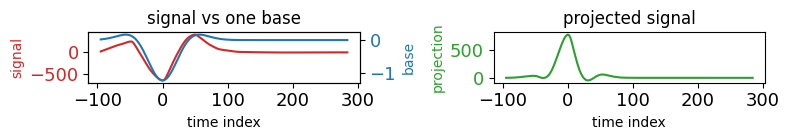

In [3]:
def base_Mexican_hat(x_range, a=40, b=5):
    A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
    return -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)


def plot_signal_with_base(base, class_name, curve_num):
    
    fig = plt.figure(figsize=(8,1.5), dpi=100, constrained_layout=False)
    axs = fig.subplots(1, 2)
    
#    fig, ax1 = plt.subplots(figsize=(4,1.5), dpi=100)

    X_ = motions.filteredMotions[class_name][curve_num]

    direction = class_name.split("/")[1]
    if direction == "LR":
        loc_peak = np.argmin(X_)
        phase = 1 
    else:
        loc_peak = np.argmax(X_)
        phase = -1
        
    x_range = np.arange(-loc_peak, loc_peak*3)
    y_signal = X_[:len(x_range)]
    y_base = phase * base(x_range)
    y_moment_computing = y_signal*y_base 
        
    color = 'tab:red'
    axs[0].set_xlabel('time index')
    axs[0].set_ylabel('signal', color=color)
    axs[0].plot(x_range, y_signal, color=color)
    axs[0].tick_params(axis='y', labelcolor=color)
    axs[0].set_title('signal vs one base')
    ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('base', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_range, y_base, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'tab:green'
    axs[1].set_xlabel('time index')
    axs[1].set_ylabel('projection', color=color)
    axs[1].plot(x_range, y_moment_computing, color=color)
    axs[1].tick_params(axis='y', labelcolor=color)
    axs[1].set_title('projected signal')
    moment_computing = np.dot(x_range, y_base)
    print("{}, {}, : {}".format(class_name, curve_num, moment_computing))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()    
    
plot_signal_with_base(base_Mexican_hat, 'fast/LR/1m', 1)

fast/RL/1m, 1, : -105.05148278144785


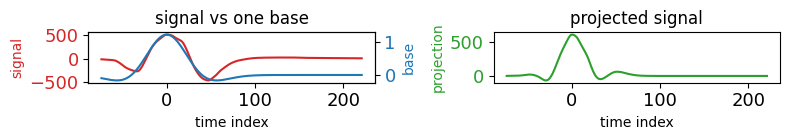

In [4]:
plot_signal_with_base(base_Mexican_hat, 'fast/RL/1m', 1)

In [5]:
classes_dict = {class_name: i for i,class_name in enumerate(motions.classes)} 
classes_dict    

{'fast/LR/1m': 0,
 'fast/LR/2m': 1,
 'fast/LR/3m': 2,
 'fast/LR/4m': 3,
 'fast/LR/5m': 4,
 'fast/LR/left': 5,
 'fast/LR/right': 6,
 'fast/RL/1m': 7,
 'fast/RL/2m': 8,
 'fast/RL/3m': 9,
 'fast/RL/4m': 10,
 'fast/RL/5m': 11,
 'fast/RL/left': 12,
 'fast/RL/right': 13,
 'slow/LR/1m': 14,
 'slow/LR/2m': 15,
 'slow/LR/3m': 16,
 'slow/LR/4m': 17,
 'slow/LR/5m': 18,
 'slow/LR/left': 19,
 'slow/LR/right': 20,
 'slow/RL/1m': 21,
 'slow/RL/2m': 22,
 'slow/RL/3m': 23,
 'slow/RL/4m': 24,
 'slow/RL/5m': 25,
 'slow/RL/left': 26,
 'slow/RL/right': 27}

In [6]:
def base_set(x_range):
    num_base = 20 
    a0 = 10
    b = 5 # fixed 
    da = 5
    y_base = np.zeros(shape=(num_base, len(x_range)))
    for i in range(num_base): 
        a = a0 + i*da 
        A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
        y_base[i] = -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)
        
    return y_base


def cal_momentComputing(class_name):

    num_base = 20 
    moment_computing = [] 
    signals = motions.filteredMotions[class_name]
    
    direction = class_name.split("/")[1]
    
    moment_computing =[]
    
    for i, sig in enumerate(signals):

        if direction == "LR":
            loc_peak = np.argmin(sig)
            phase = 1 
        else:
            loc_peak = np.argmax(sig)
            phase = -1
        
        #loc_peak = np.argmin(sig)
        x_range = np.arange(-loc_peak, loc_peak*3)

        if len(x_range) > 1200: 
            continue 

        y_signal = sig[:len(x_range)]
        y_bases = phase*base_set(x_range)
                
        vec_set = [] 
        for idx_vec in range(num_base):
            vec_set.append(np.dot(y_signal, y_bases[idx_vec]))
            
        vec_set.append(class_name)

        moment_computing.append(vec_set)
    
    return moment_computing


### plot base set 

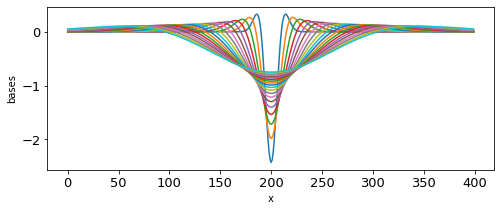

In [7]:
y_bases = base_set(np.arange(-200,200))
plt.figure(figsize=(8,3))
for y in y_bases:
    plt.plot(y)
_=plt.ylabel("bases")
_=plt.xlabel("x")

### Moment Computing 

In [8]:
dist = {} 
moment_collection = [] 
for class_name in motions.classes:     
    moment = cal_momentComputing(class_name)
    for m in moment: 
        moment_collection.append(m)
#    print(class_name, motions.filteredMotions[class_name].shape[0])
    dist[class_name] = motions.filteredMotions[class_name].shape[0]


### Build a dataset 

In [9]:
df = pd.DataFrame(np.array(moment_collection))
df.columns=['base'+str(i+1) for i in range(20)] + ['class_name']
display(df.head())
display(df.tail())

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,10563.790067539232,13653.800646394604,16373.345212055385,18420.52051018493,19617.047945281414,19994.98015804572,19706.814659610747,18938.129594854287,17861.577730953577,16617.58141378464,...,14009.030516970923,12759.351935163075,11586.01188231587,10501.176146197411,9508.619094515681,8606.97814721386,7791.935407211868,7057.627433044193,6397.528716941249,fast/LR/1m
1,14626.511350111627,18298.532434077493,21288.442088559008,23439.7529241143,24547.690075483973,24630.82050869769,23898.01721502633,22614.586066852564,21017.747869657098,19287.234497681107,...,15867.93444837648,14297.43111612093,12853.703293842067,11542.411095774101,10360.750941869375,9301.261159854359,8354.234433646707,7509.188093691231,6755.720148668153,fast/LR/1m
2,13416.759507009385,17209.525601739384,20526.1254463387,23048.464672173115,24579.887534910078,25131.156608557474,24857.0101686197,23967.45510960245,22668.738248401645,21134.462179243623,...,17848.064829375202,16248.994597531939,14735.493641931578,13326.437448969906,12029.237374480139,10844.041497654265,9766.676168978425,8790.617719475526,7908.260380934733,fast/LR/1m
3,17343.086503127633,21930.841082921608,25748.68589053599,28627.548853298897,30344.271836734406,30861.109714755497,30349.025878844317,29080.198912045962,27330.15022895009,25327.348528183968,...,21178.105872260494,19211.809515538167,17377.522601294753,15691.436397812598,14156.606517208807,12768.325887218252,11517.680972786497,10393.805284268677,9385.246384640264,fast/LR/1m
4,18633.83032061867,23818.49289762111,28228.84944438396,31621.875465128738,33790.2091118597,34691.73433263716,34473.24636736879,33392.029763273575,31725.700613137014,29717.087189105267,...,25367.032443226824,23243.330006835356,21233.439587905275,19363.937014474133,17645.171355634266,16077.274023179429,14654.333037190147,13367.172791110437,12205.135184929217,fast/LR/1m


,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
4445,9987.771059467894,12743.498590264904,15254.384477811655,17321.763559832536,18775.20974782702,19575.31814493686,19785.72825275699,19521.287501001545,18905.4242028211,18046.09984544919,...,15916.835170362094,14759.071292308465,13590.980458456977,12439.179133561898,11323.110344278615,10256.455317780234,9248.240803885128,8303.778994746091,7425.487415275792,slow/RL/right
4446,10946.551995957538,13742.39470321285,16061.759532472039,17924.18310529258,19372.995444990094,20494.532443874275,21368.26856798322,22029.462341124487,22473.655032452974,22681.997899124915,...,22365.94260304801,21873.28780772874,21201.681648220583,20391.81562570437,19483.812928917258,18513.881814448905,17512.681845605126,16504.903973974186,15509.585020018163,slow/RL/right
4447,11303.616446059867,14126.632082436172,16708.54405266654,19108.108580596112,21214.23705457624,22915.345263202766,24145.580641232256,24882.300079049684,25142.811663937027,24977.39243768291,...,23662.578142011647,22670.26258691198,21549.097097334896,20355.81587172212,19134.83047524756,17919.302301448977,16732.893960371428,15591.661502612375,14505.800039002042,slow/RL/right
4448,11843.83420248743,14764.615700045044,17241.012181359452,19394.42218036394,21259.61791977365,22801.290999513876,23972.397324186466,24740.478876549947,25099.56301476561,25074.419479331398,...,24089.306544830637,23264.31240645762,22305.055337012258,21266.26690348268,20191.652560629478,19114.343284196017,18058.28787794776,17039.943320578168,16069.912916612106,slow/RL/right
4449,19394.327369963277,24445.243589602338,28958.75044267886,32878.21155372953,36079.027444048115,38465.71816159808,40025.80890463102,40821.72971136535,40958.610429029424,40556.88283755485,...,38598.31724506678,37238.57114373884,35730.137051186,34132.887998664635,32493.7258978917,30848.57373112656,29224.271772662927,27640.288203581447,26110.213984698257,slow/RL/right


### Data augmentation using SMOTE

In [10]:
import imblearn
from imblearn.over_sampling import SMOTE 

y_org = df['class_name'].values
x_org = df.iloc[:,:20].values 

sm = SMOTE(random_state=42)
X_augmented, y_augmented = sm.fit_resample(x_org, y_org)

### Principal Component analysis

In [11]:
subClass = [] 

for class_name in motions.classes: 
    s = os.path.join(*class_name.split("/")[1:]) 
    if s not in subClass: 
        subClass.append(s)
    
print(subClass)

['LR/1m', 'LR/2m', 'LR/3m', 'LR/4m', 'LR/5m', 'LR/left', 'LR/right', 'RL/1m', 'RL/2m', 'RL/3m', 'RL/4m', 'RL/5m', 'RL/left', 'RL/right']


In [12]:
pairClass = [] 
for s in subClass: 
    pairClass.append(['fast/'+s, 'slow/'+ s])
    
for p in pairClass:
    print(p)

['fast/LR/1m', 'slow/LR/1m']
['fast/LR/2m', 'slow/LR/2m']
['fast/LR/3m', 'slow/LR/3m']
['fast/LR/4m', 'slow/LR/4m']
['fast/LR/5m', 'slow/LR/5m']
['fast/LR/left', 'slow/LR/left']
['fast/LR/right', 'slow/LR/right']
['fast/RL/1m', 'slow/RL/1m']
['fast/RL/2m', 'slow/RL/2m']
['fast/RL/3m', 'slow/RL/3m']
['fast/RL/4m', 'slow/RL/4m']
['fast/RL/5m', 'slow/RL/5m']
['fast/RL/left', 'slow/RL/left']
['fast/RL/right', 'slow/RL/right']


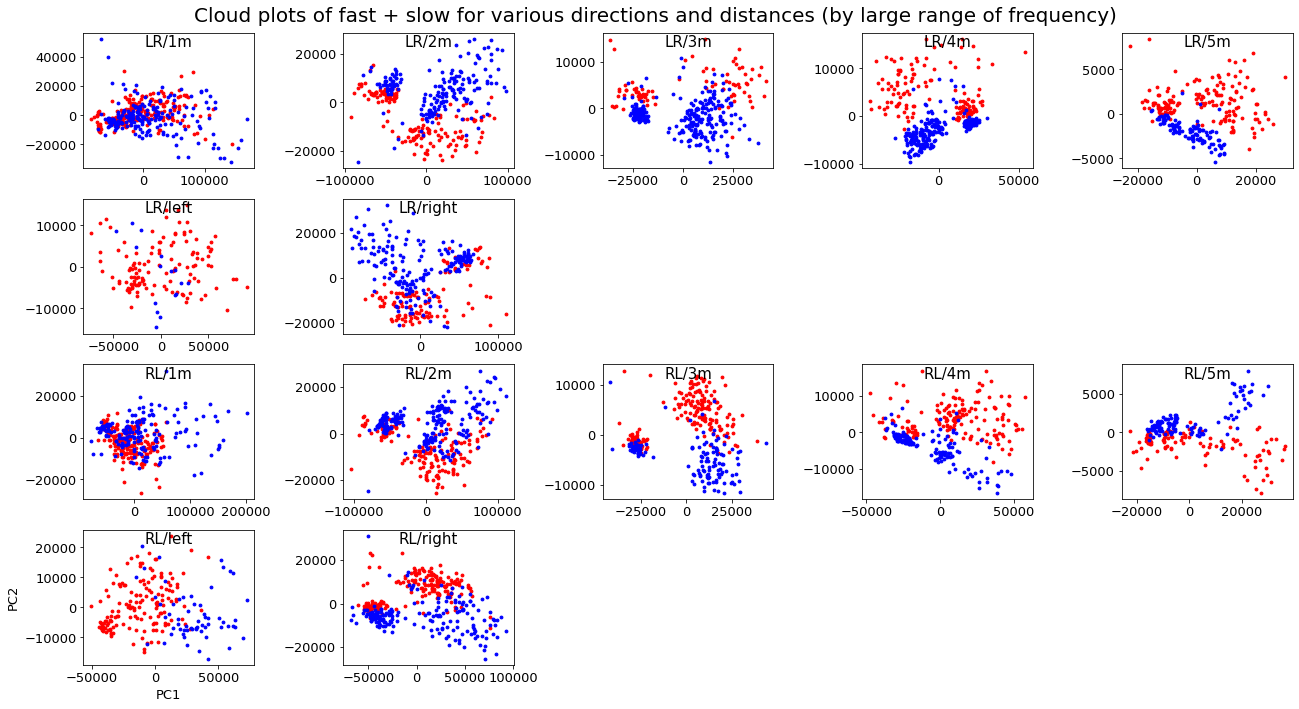

In [13]:
def PCA_for_speeds(class_pair):
    class1, class2 = class_pair
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    target = df_fs.pop('class_name') 
    target.reset_index(drop=True,inplace=True) 
    X = df_fs
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, target], axis = 1)
    
    return finalDf
    

def ListPlotClouds(): 
    
    fig = plt.figure(figsize=(18, 10), constrained_layout=False)
    n_row, n_col = 4, 5
    axs = fig.subplots(n_row, n_col)
    plt.suptitle("Cloud plots of fast + slow for various directions and distances (by large range of frequency)", 
                 fontsize=20)
    
    idx_pair = 0 
    for r in range(n_row):         
        for c in range(n_col):
            if r%2==1 and c > 1: 
                axs[r, c].axis('off')
            else: 
                axs[r, c].set_title(str(subClass[idx_pair]), 
                                    y=1.0, pad=-14, 
                                    c='k', 
                                    fontsize=15)
                df_pc = PCA_for_speeds(pairClass[idx_pair])
                class1,class2 = pairClass[idx_pair]
                df_cl1 = df_pc[df_pc['class_name']==class1]
                df_cl2 = df_pc[df_pc['class_name']==class2]
                axs[r, c].scatter(df_cl1['PC1'], df_cl1['PC2'], c='red', s=8)
                axs[r, c].scatter(df_cl2['PC1'], df_cl2['PC2'], c='blue', s=8)
                
                idx_pair +=1
    
    axs[3,0].set_xlabel('PC1', fontsize=13)
    axs[3,0].set_ylabel('PC2', fontsize=13)
    
    plt.tight_layout()
    plt.savefig('cloudPlotFordifferentSpeeds_largerRange.pdf')  

ListPlotClouds()

## Predictive models

### binary Classification 
#### Logistic Regression Model 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [15]:
def logisticRegression(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    n = df_fs.shape[0]
    train_df = df_fs[0:int(n*0.8)]
    test_df = df_fs[int(n*0.8):]

    train_y = train_df.pop('class_name')
    train_X = train_df  

    test_y = test_df.pop('class_name')
    test_X = test_df  

    clf = LogisticRegression(random_state=0).fit(train_X, train_y)

    return clf.score(test_X, test_y)

print(logisticRegression('fast/LR/1m', 'slow/LR/1m'))
print(logisticRegression('fast/LR/3m', 'slow/LR/3m'))
print(logisticRegression('fast/LR/5m', 'slow/LR/5m'))

0.8023255813953488
0.9285714285714286
0.8727272727272727


In [16]:
print(logisticRegression('fast/RL/1m', 'slow/RL/1m'))
print(logisticRegression('fast/RL/3m', 'slow/RL/3m'))
print(logisticRegression('fast/RL/5m', 'slow/RL/5m'))

0.7183098591549296
0.8307692307692308
0.8333333333333334


In [17]:
print(logisticRegression('fast/RL/left', 'slow/RL/left'))
print(logisticRegression('fast/RL/right', 'slow/RL/right'))

0.7906976744186046
0.8875


In [18]:
print(logisticRegression('fast/LR/left', 'slow/LR/left'))
print(logisticRegression('fast/LR/right', 'slow/LR/right'))

0.8928571428571429
0.8064516129032258


#### Neural Networks 

In [19]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split



In [20]:
def get_speeds_data(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    return df_fs

In [21]:
df_fs = get_speeds_data('fast/LR/1m', 'slow/LR/1m')
display(df_fs)

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,18620.29730224819,24052.082563955475,28709.29775866201,32083.043986783276,33945.86288747539,34358.43209337063,33575.91082388461,31935.928018607534,29764.00693247906,27323.47619875679,...,22329.668670865976,19975.911473087537,17782.90705810712,15768.195069280475,13935.076308746378,12278.409498087973,10788.379465328895,9452.86706184781,8258.895952048237,fast/LR/1m
1,23625.21916688625,30064.603986026053,35324.12413225639,39270.10102308535,41740.052021033334,42701.41549284395,42341.3309853418,40977.60844947123,38941.30673353557,36512.01951125921,...,31251.659513924053,28662.796596827666,26191.9870136245,23871.79894109188,21717.27485480147,19732.05984610672,17912.683710428904,16251.476606501756,14738.506740075118,fast/LR/1m
2,13438.328190528116,17145.781701519092,20055.106604196983,21954.1732834691,22754.960129260326,22552.92363939873,21589.852680649507,20147.33736180129,18466.271946488614,16718.979773517298,...,13412.092646686036,11941.935699299054,10612.588808070146,9421.807274398207,8361.4268575982,7420.605103689817,6587.682094863298,5851.1880714409635,5200.346134762374,slow/LR/1m
3,10436.624572465405,13721.910575758075,16508.283950820376,18280.345615316815,18932.701416930504,18606.62317365251,17556.680996980685,16051.844371693758,14316.613608629454,12512.834231945064,...,9074.082856193327,7530.715775568231,6126.6624265762475,4862.286691907492,3731.665496588753,2725.7100886003636,1834.003912866912,1045.8436699937802,350.8082009258519,fast/LR/1m
4,16184.753476077483,20669.168119977017,24243.040317342475,26557.75157589282,27427.32877109376,26982.717502026724,25560.499718260668,23535.069753129985,21218.807254218365,18832.99436772267,...,14348.010417558075,12363.893547302563,10576.183015468698,8981.937880920745,7570.2514233764305,6326.39517248261,5234.276311107047,4277.842585128354,3441.8423374444346,slow/LR/1m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,18808.252562803642,23873.639397601157,28108.576997274427,31289.962660923982,33190.95358606755,33772.38374042741,33214.49333360912,31814.190789386637,29877.230597836424,27658.68014419558,...,23063.15711177322,20887.23630428398,18859.525824396307,16998.504055030113,15308.01559071686,13783.130162167388,12414.031710039315,11188.518512684426,10093.56069892022,fast/LR/1m
426,19317.80425325821,24840.576692304538,29382.68216970704,32448.20901169969,33832.48799776981,33684.13646296103,32368.82191267643,30301.23565483935,27837.33578591914,25237.174504370123,...,20235.57644194782,17984.97025657898,15938.93369217324,14099.626263150203,12458.734390227293,11002.507641545411,9714.8225587239,8578.989639162704,7578.776679181296,slow/LR/1m
427,11686.863362200294,15112.671842271162,17897.549914993055,19652.82612825079,20267.776619409044,19904.28084371519,18851.936225721918,17397.946330951825,15765.368403944696,14104.005011326504,...,11013.301357444943,9653.67920881162,8430.59451336268,7340.620297880307,6375.611865923778,5525.216225621457,4778.320104050164,4123.873969460039,3551.351107789793,fast/LR/1m
428,10838.39842226525,13634.284333669611,15801.620471839447,17244.339690461897,17860.74514756616,17688.00553243931,16898.785564706206,15706.874928713387,14299.321344256801,12814.133748238595,...,9940.308584291233,8636.594248975685,7444.542431052834,6366.678335668581,5399.4166575406025,4535.867768001465,3767.5906762031163,3085.6502782469015,2481.2314326770393,fast/LR/1m


In [22]:
y = df_fs.pop('class_name')
X = df_fs.values

In [23]:
X.shape, y.shape

((430, 20), (430,))

In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

##### sklearn

In [25]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=20, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
def skln_binaryClassification(class1, class2):
    
    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    encoded_y = LabelEncoder().fit_transform(y)
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    results = cross_val_score(pipeline, X, encoded_y, cv=kfold)
    
    print("{} vs {}".format(class1, class2))
    print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [27]:
# skln_binaryClassification('fast/LR/1m', 'slow/LR/1m')
# skln_binaryClassification('fast/LR/5m', 'slow/LR/5m')
# skln_binaryClassification('fast/LR/1m', 'fast/RL/1m')
# skln_binaryClassification('fast/LR/5m', 'fast/RL/5m')

##### tensorflow

In [28]:
def plot_loss(history, epochs): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Loss')
    plt.show()


In [29]:

# from keras import backend
# print(backend.tensorflow_backend._get_available_gpus())

In [30]:
def get_optimizer():
      return tf.keras.optimizers.Adam(learning_rate=0.01)


### Multiclass Classification 

#### sub-groups Classification 

In [31]:
def nn_binaryClassification(class1, class2, batch_size):

    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    print(X.shape, y.shape)
    
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
#    dummy_y = np_utils.to_categorical(encoded_y)
    
    # split into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, encoded_y, test_size=0.3, random_state=0)

    
    model = keras.Sequential([
        keras.layers.Dense(8, input_shape=(scaled_X.shape[1],),
                            activation=tf.nn.elu, 
                            kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5),
        keras.layers.Dense(1,activation=tf.nn.sigmoid),    
    ])

    model.compile(optimizer=get_optimizer(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epoch = 500 
    history = model.fit(X_train, y_train, epochs=epoch,  
                        validation_split=0.2, 
                        batch_size=batch_size,
                        verbose=0)
    
    model.evaluate(X_test, y_test)
    
    plot_loss(history, epochs=epoch)

(512, 20) (512,)
Metal device set to: Apple M1


2021-08-18 14:06:51.314987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-18 14:06:51.315074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-08-18 14:06:51.360031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-18 14:06:51.360215: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-18 14:06:51.487002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:06:51.657400: I tensorflow/core/grappler/

5/5 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.7597


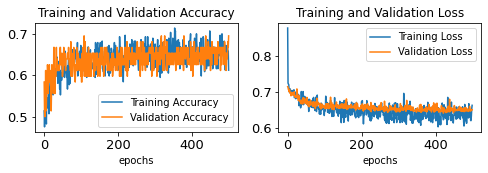

(512, 20) (512,)


2021-08-18 14:07:21.545340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:07:21.683357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6753


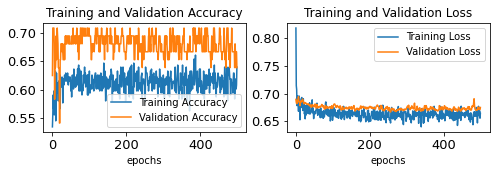

(512, 20) (512,)


2021-08-18 14:07:50.822984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:07:50.962471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.5927 - accuracy: 0.7273


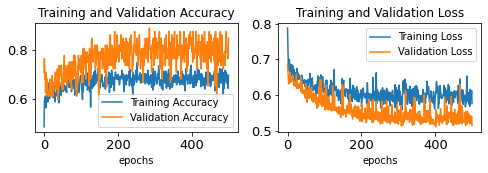

(512, 20) (512,)


2021-08-18 14:08:20.168607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:08:20.306106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6364


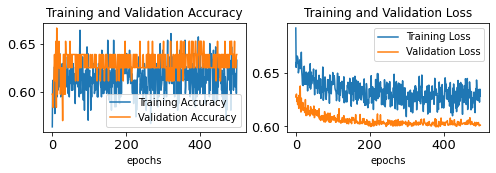

(512, 20) (512,)


2021-08-18 14:08:49.493930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:08:49.632712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.6149 - accuracy: 0.6169


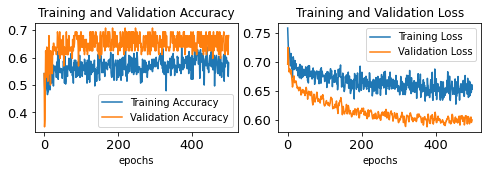

CPU times: user 2min 19s, sys: 1min 31s, total: 3min 50s
Wall time: 2min 27s


In [32]:
%%time 
batch_size = 32
nn_binaryClassification('fast/RL/1m', 'fast/LR/1m', batch_size)
nn_binaryClassification('fast/RL/2m', 'fast/LR/2m', batch_size)
nn_binaryClassification('fast/RL/3m', 'fast/LR/3m', batch_size)
nn_binaryClassification('fast/RL/4m', 'fast/LR/4m', batch_size)
nn_binaryClassification('fast/RL/5m', 'fast/LR/5m', batch_size)

(512, 20) (512,)


2021-08-18 14:09:18.953134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:09:19.092238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.6039


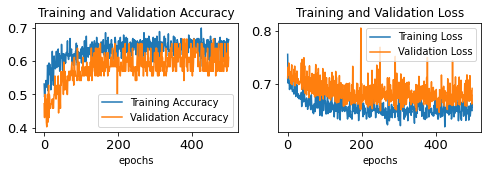

(512, 20) (512,)


2021-08-18 14:09:48.221543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:09:48.359057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.7078


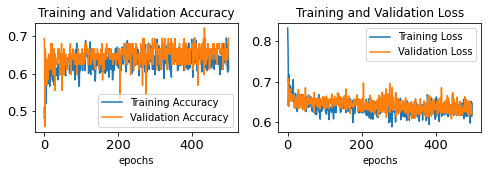

(512, 20) (512,)


2021-08-18 14:10:17.673493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:10:17.809064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.4758 - accuracy: 0.8831


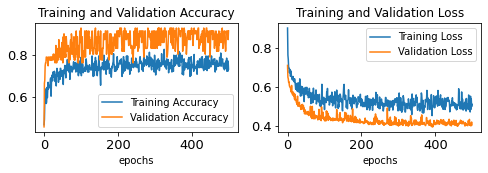

(512, 20) (512,)


2021-08-18 14:10:47.191944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:10:47.328986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.6036 - accuracy: 0.6623


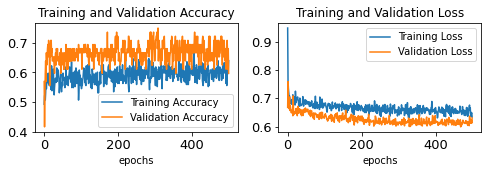

(512, 20) (512,)


2021-08-18 14:11:16.595129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:11:16.732788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.4134 - accuracy: 0.8312


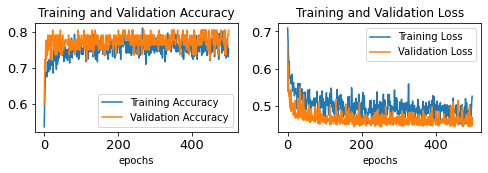

CPU times: user 2min 19s, sys: 1min 30s, total: 3min 50s
Wall time: 2min 27s


In [33]:
%%time 
nn_binaryClassification('slow/RL/1m', 'slow/LR/1m', batch_size)
nn_binaryClassification('slow/RL/2m', 'slow/LR/2m', batch_size)
nn_binaryClassification('slow/RL/3m', 'slow/LR/3m', batch_size)
nn_binaryClassification('slow/RL/4m', 'slow/LR/4m', batch_size)
nn_binaryClassification('slow/RL/5m', 'slow/LR/5m', batch_size)

(512, 20) (512,)


2021-08-18 14:11:45.986493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:11:46.125568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.4782 - accuracy: 0.7597


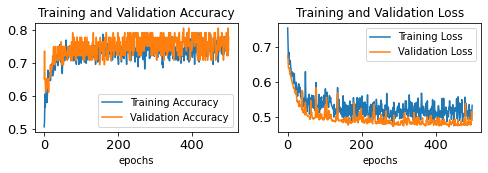

(512, 20) (512,)


2021-08-18 14:12:15.306407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:12:15.443552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.4108 - accuracy: 0.7857


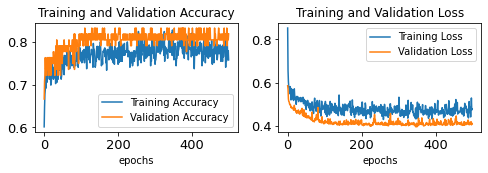

(512, 20) (512,)


2021-08-18 14:12:43.584983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:12:43.725199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 4ms/step - loss: 0.2904 - accuracy: 0.9156


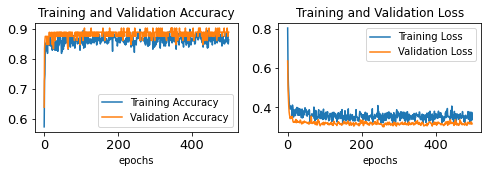

(512, 20) (512,)


2021-08-18 14:13:13.082213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:13:13.220155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.2448 - accuracy: 0.9156


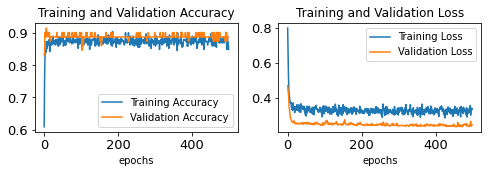

(512, 20) (512,)


2021-08-18 14:13:42.326475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:13:42.464023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.2503 - accuracy: 0.9026


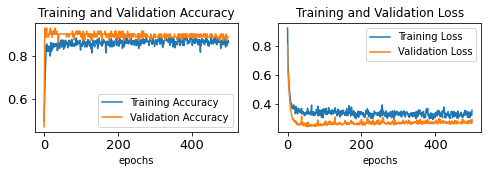

CPU times: user 2min 18s, sys: 1min 27s, total: 3min 46s
Wall time: 2min 24s


In [34]:
%%time
nn_binaryClassification('fast/RL/1m', 'slow/RL/1m', batch_size)
nn_binaryClassification('fast/RL/2m', 'slow/RL/2m', batch_size)
nn_binaryClassification('fast/RL/3m', 'slow/RL/3m', batch_size)
nn_binaryClassification('fast/RL/4m', 'slow/RL/4m', batch_size)
nn_binaryClassification('fast/RL/5m', 'slow/RL/5m', batch_size)

In [35]:
motions.classes

['fast/LR/1m',
 'fast/LR/2m',
 'fast/LR/3m',
 'fast/LR/4m',
 'fast/LR/5m',
 'fast/LR/left',
 'fast/LR/right',
 'fast/RL/1m',
 'fast/RL/2m',
 'fast/RL/3m',
 'fast/RL/4m',
 'fast/RL/5m',
 'fast/RL/left',
 'fast/RL/right',
 'slow/LR/1m',
 'slow/LR/2m',
 'slow/LR/3m',
 'slow/LR/4m',
 'slow/LR/5m',
 'slow/LR/left',
 'slow/LR/right',
 'slow/RL/1m',
 'slow/RL/2m',
 'slow/RL/3m',
 'slow/RL/4m',
 'slow/RL/5m',
 'slow/RL/left',
 'slow/RL/right']

In [36]:
motions.classes[:14]

['fast/LR/1m',
 'fast/LR/2m',
 'fast/LR/3m',
 'fast/LR/4m',
 'fast/LR/5m',
 'fast/LR/left',
 'fast/LR/right',
 'fast/RL/1m',
 'fast/RL/2m',
 'fast/RL/3m',
 'fast/RL/4m',
 'fast/RL/5m',
 'fast/RL/left',
 'fast/RL/right']

In [37]:
m = motions.classes[0]
m.replace(m[5:7], m[5:7][::-1])
print(m)

fast/LR/1m


In [38]:
speed_based = {}

for m in motions.classes:
    key = m[5:] 
    if m[:4] == 'fast': 
        different_speed = 'slow' + m[4:]
    else: 
        different_speed = 'fast' + m[4:]
    
    if key not in speed_based:
        speed_based[key] = [m, different_speed]
    
speed_based    

{'LR/1m': ['fast/LR/1m', 'slow/LR/1m'],
 'LR/2m': ['fast/LR/2m', 'slow/LR/2m'],
 'LR/3m': ['fast/LR/3m', 'slow/LR/3m'],
 'LR/4m': ['fast/LR/4m', 'slow/LR/4m'],
 'LR/5m': ['fast/LR/5m', 'slow/LR/5m'],
 'LR/left': ['fast/LR/left', 'slow/LR/left'],
 'LR/right': ['fast/LR/right', 'slow/LR/right'],
 'RL/1m': ['fast/RL/1m', 'slow/RL/1m'],
 'RL/2m': ['fast/RL/2m', 'slow/RL/2m'],
 'RL/3m': ['fast/RL/3m', 'slow/RL/3m'],
 'RL/4m': ['fast/RL/4m', 'slow/RL/4m'],
 'RL/5m': ['fast/RL/5m', 'slow/RL/5m'],
 'RL/left': ['fast/RL/left', 'slow/RL/left'],
 'RL/right': ['fast/RL/right', 'slow/RL/right']}

In [39]:
direction_based = {}

for m in motions.classes:
    key = m[:4] + m[7:] # m[5:7] + ".." + m[5:7][::-1] + m[7:]
    inverted_direction = m.replace(m[5:7],  m[5:7][::-1])
    
    if key not in direction_based:
        direction_based[key] = [m, inverted_direction]
    
direction_based    

{'fast/1m': ['fast/LR/1m', 'fast/RL/1m'],
 'fast/2m': ['fast/LR/2m', 'fast/RL/2m'],
 'fast/3m': ['fast/LR/3m', 'fast/RL/3m'],
 'fast/4m': ['fast/LR/4m', 'fast/RL/4m'],
 'fast/5m': ['fast/LR/5m', 'fast/RL/5m'],
 'fast/left': ['fast/LR/left', 'fast/RL/left'],
 'fast/right': ['fast/LR/right', 'fast/RL/right'],
 'slow/1m': ['slow/LR/1m', 'slow/RL/1m'],
 'slow/2m': ['slow/LR/2m', 'slow/RL/2m'],
 'slow/3m': ['slow/LR/3m', 'slow/RL/3m'],
 'slow/4m': ['slow/LR/4m', 'slow/RL/4m'],
 'slow/5m': ['slow/LR/5m', 'slow/RL/5m'],
 'slow/left': ['slow/LR/left', 'slow/RL/left'],
 'slow/right': ['slow/LR/right', 'slow/RL/right']}

In [40]:
distance_based = {}
distance_based['fast/LR/1m...5m'] = motions.classes[:5]
distance_based['fast/RL/1m...5m'] = motions.classes[7:7+5]
distance_based['slow/LR/1m...5m'] = motions.classes[14:14+5]
distance_based['slow/RL/1m...5m'] = motions.classes[-7:-2]
distance_based

{'fast/LR/1m...5m': ['fast/LR/1m',
  'fast/LR/2m',
  'fast/LR/3m',
  'fast/LR/4m',
  'fast/LR/5m'],
 'fast/RL/1m...5m': ['fast/RL/1m',
  'fast/RL/2m',
  'fast/RL/3m',
  'fast/RL/4m',
  'fast/RL/5m'],
 'slow/LR/1m...5m': ['slow/LR/1m',
  'slow/LR/2m',
  'slow/LR/3m',
  'slow/LR/4m',
  'slow/LR/5m'],
 'slow/RL/1m...5m': ['slow/RL/1m',
  'slow/RL/2m',
  'slow/RL/3m',
  'slow/RL/4m',
  'slow/RL/5m']}

#### multi-class classification 

In [41]:
def nn_multiClass_Classification(class_list, batch_size):
    n_classes = len(class_list)
    print("list of classes (n_classes={})".format(n_classes))
    for c in class_list: print(c)    
    print("---")

    y = []
    X_multiClass = []
    for m in class_list:
        X_multiClass.append(X_augmented[y_augmented == m])
        y.append(y_augmented[y_augmented == m])

    X = np.vstack(X_multiClass)
    y = np.hstack(y)
    
    print("size of dataset: input {} and target {}".format(X.shape, y.shape))
        
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_y)
        
    # split into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, dummy_y, test_size=0.3, random_state=0)

    model = keras.Sequential([
        keras.layers.Dense(16, input_dim=X.shape[1], 
                           kernel_regularizer=regularizers.l2(0.001),
                           activation='elu'),
        Dropout(0.5),                
        keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                   activation='elu'),
        Dropout(0.5),                

        keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                   activation='elu'),
        Dropout(0.5),                

        keras.layers.Dense(n_classes, activation='softmax'),    
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    epoch = 200 
    history = model.fit(X_train, y_train, 
                        epochs=epoch,  
                        validation_split=0.2, 
                        batch_size=batch_size,
                        verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test)    

    plot_loss(history, epochs=epoch)

    return loss, accuracy

##### Distance-based Classification 

fast/LR/1m...5m
list of classes (n_classes=5)
fast/LR/1m
fast/LR/2m
fast/LR/3m
fast/LR/4m
fast/LR/5m
---
size of dataset: input (1280, 20) and target (1280,)


2021-08-18 14:14:11.296924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:14:11.619589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 7ms/step - loss: 0.9202 - accuracy: 0.5781


2021-08-18 14:14:55.634975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


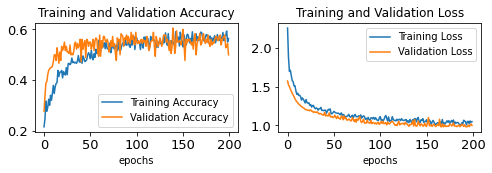

fast/RL/1m...5m
list of classes (n_classes=5)
fast/RL/1m
fast/RL/2m
fast/RL/3m
fast/RL/4m
fast/RL/5m
---
size of dataset: input (1280, 20) and target (1280,)


2021-08-18 14:14:55.981451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:14:56.284636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 7ms/step - loss: 0.7484 - accuracy: 0.7370


2021-08-18 14:15:40.398838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


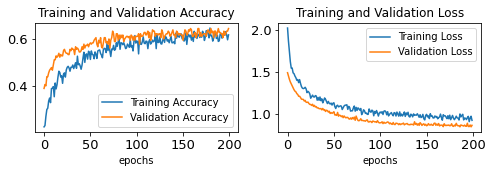

slow/LR/1m...5m
list of classes (n_classes=5)
slow/LR/1m
slow/LR/2m
slow/LR/3m
slow/LR/4m
slow/LR/5m
---
size of dataset: input (1280, 20) and target (1280,)


2021-08-18 14:15:40.748367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:15:41.049412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 7ms/step - loss: 0.7279 - accuracy: 0.6849


2021-08-18 14:16:25.286801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


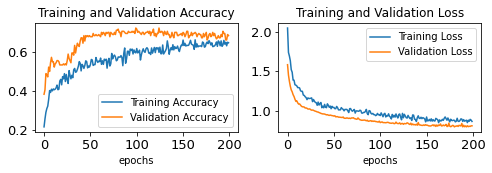

slow/RL/1m...5m
list of classes (n_classes=5)
slow/RL/1m
slow/RL/2m
slow/RL/3m
slow/RL/4m
slow/RL/5m
---
size of dataset: input (1280, 20) and target (1280,)


2021-08-18 14:16:25.636096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:16:25.943631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 6ms/step - loss: 0.7438 - accuracy: 0.7057


2021-08-18 14:17:10.309170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


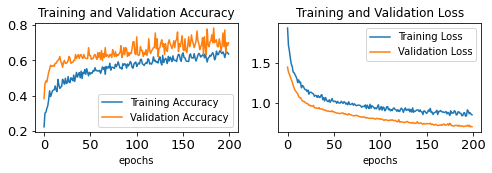

CPU times: user 2min 38s, sys: 1min 37s, total: 4min 16s
Wall time: 2min 59s


In [42]:
%%time
res={}
for key in distance_based.keys(): 
    print(key)
    res[key] = nn_multiClass_Classification(distance_based[key], batch_size=32)
    

In [92]:
def plot_subclass_classification_result(res, figure_title):
    df = pd.DataFrame(res).T
    df.columns = ["loss", "accuracy"]
    
    df.plot(y=["loss", "accuracy"], kind="bar", figsize=(10,3))
    _ = plt.xticks(rotation=0)

    plt.title(figure_title,fontsize=13)
    #plt.xlabel("Sub-class group",fontsize=13)
    plt.ylabel("Evaluation score",fontsize=13)
    plt.xticks(rotation=30)
    

    if max(df.max()) < 1: 
        plt.ylim(0, 1)
        
    _ = plt.legend(fontsize=13, bbox_to_anchor=(1.,1), loc='upper left')
    plt.grid(color='grey',linestyle='--',linewidth=0.5,axis='y', alpha=0.3)

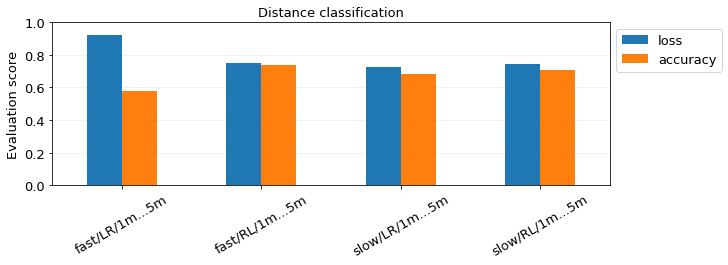

In [93]:
plot_subclass_classification_result(res, "Distance classification")

##### Direction-based Classification 

list of classes (n_classes=2)
fast/LR/1m
fast/RL/1m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:17:10.748226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:17:10.933708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.6427 - accuracy: 0.6688


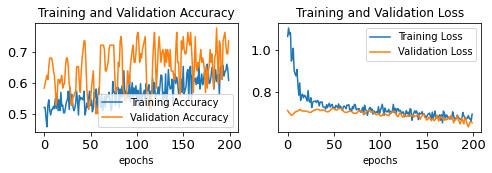

list of classes (n_classes=2)
fast/LR/2m
fast/RL/2m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:21:58.341899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:21:58.564531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6626 - accuracy: 0.6364


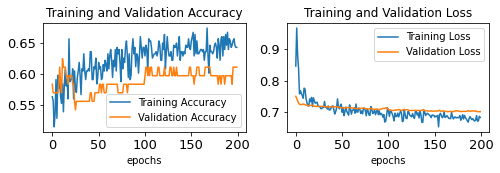

list of classes (n_classes=2)
fast/LR/3m
fast/RL/3m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:22:18.628293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:22:18.815137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6413 - accuracy: 0.6494


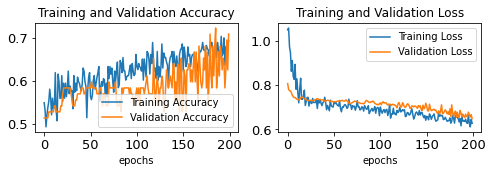

list of classes (n_classes=2)
fast/LR/4m
fast/RL/4m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:22:39.391418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:22:39.580825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6304 - accuracy: 0.6364


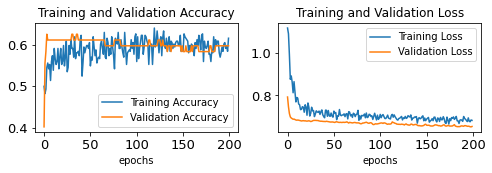

list of classes (n_classes=2)
fast/LR/5m
fast/RL/5m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:23:00.246759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:23:00.444330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.7040 - accuracy: 0.5844


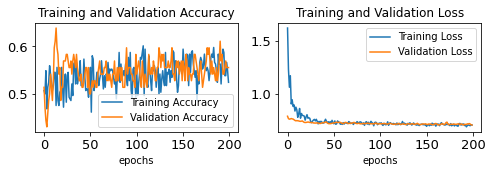

list of classes (n_classes=2)
fast/LR/left
fast/RL/left
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:23:20.916769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:23:21.108168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.4984 - accuracy: 0.8182


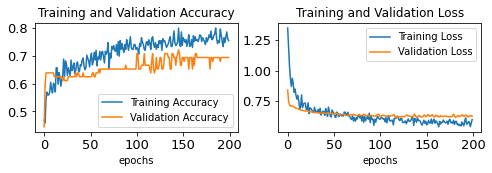

list of classes (n_classes=2)
fast/LR/right
fast/RL/right
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:23:41.458025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:23:41.662315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.7078 - accuracy: 0.5649


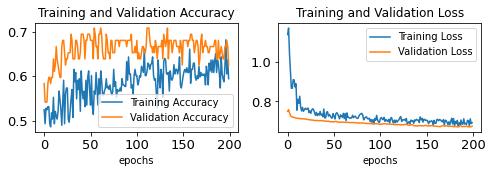

list of classes (n_classes=2)
slow/LR/1m
slow/RL/1m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:24:03.122369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:24:03.311539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.6039


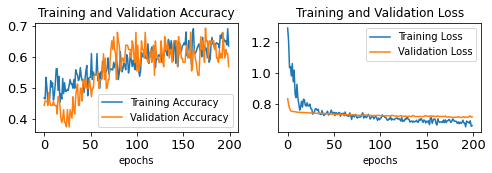

list of classes (n_classes=2)
slow/LR/2m
slow/RL/2m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:24:24.235142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:24:24.429226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6518 - accuracy: 0.6429


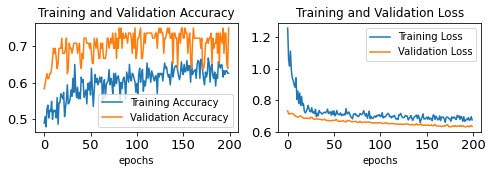

list of classes (n_classes=2)
slow/LR/3m
slow/RL/3m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:24:46.015859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:24:46.202584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 10ms/step - loss: 0.5435 - accuracy: 0.7532


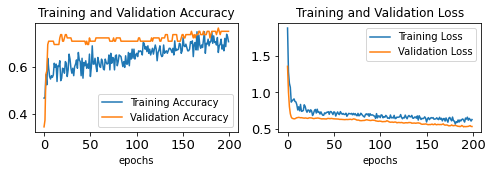

list of classes (n_classes=2)
slow/LR/4m
slow/RL/4m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:25:06.511068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:25:06.699198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.6840 - accuracy: 0.5909


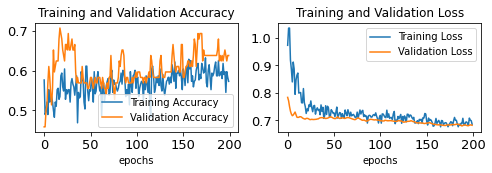

list of classes (n_classes=2)
slow/LR/5m
slow/RL/5m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:25:28.011085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:25:28.199393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.5078 - accuracy: 0.7922


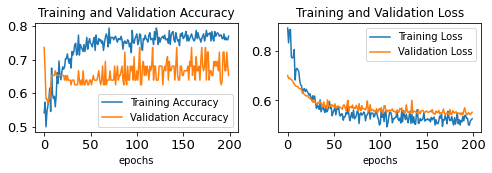

list of classes (n_classes=2)
slow/LR/left
slow/RL/left
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:25:48.418549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:25:48.604396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.2550 - accuracy: 0.8896


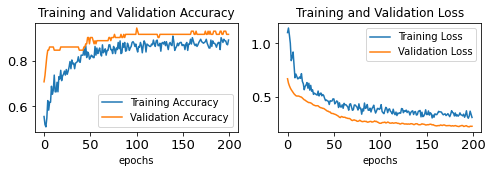

list of classes (n_classes=2)
slow/LR/right
slow/RL/right
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:26:08.852363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:26:09.043956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.5866 - accuracy: 0.7208


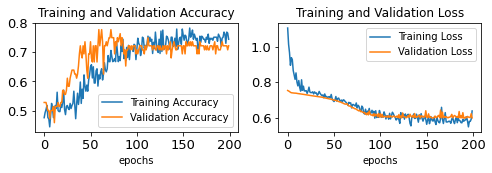

CPU times: user 4min 12s, sys: 2min 32s, total: 6min 44s
Wall time: 9min 19s


In [45]:
%%time 
res_direction_based = {} 
for key, val in direction_based.items():
    #print(key, val, type(val))
    res_direction_based[key] = nn_multiClass_Classification(val, batch_size=32)

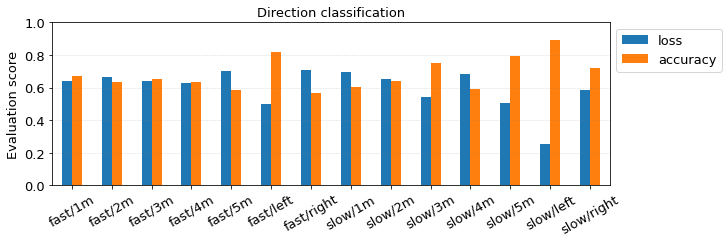

In [94]:
plot_subclass_classification_result(res_direction_based, "Direction classification")

list of classes (n_classes=2)
fast/LR/1m
slow/LR/1m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:26:29.854781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.5714 - accuracy: 0.7403


2021-08-18 14:26:30.059545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


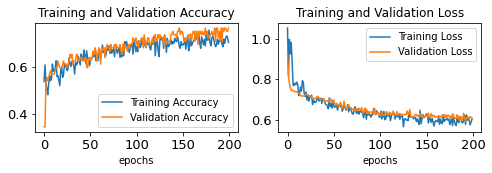

list of classes (n_classes=2)
fast/LR/2m
slow/LR/2m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:26:51.308761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:26:51.496536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 9ms/step - loss: 0.3657 - accuracy: 0.8831


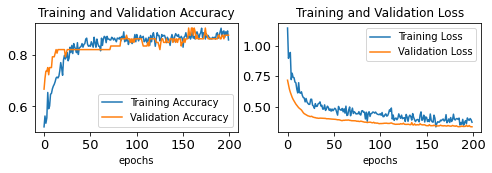

list of classes (n_classes=2)
fast/LR/3m
slow/LR/3m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:27:12.911940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:27:13.129170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.2738 - accuracy: 0.9221


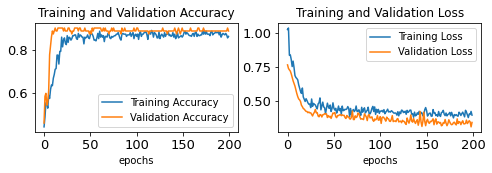

list of classes (n_classes=2)
fast/LR/4m
slow/LR/4m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:27:34.028868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:27:34.219923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.2301 - accuracy: 0.9481


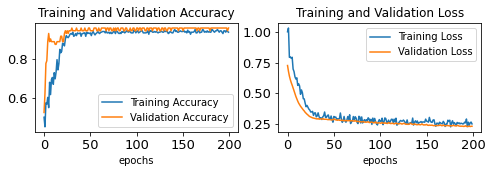

list of classes (n_classes=2)
fast/LR/5m
slow/LR/5m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:27:54.779153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:27:54.966630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.1190 - accuracy: 0.9675


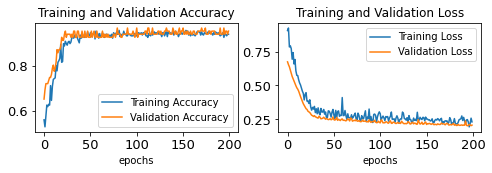

list of classes (n_classes=2)
fast/LR/left
slow/LR/left
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:28:14.916635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:28:15.104924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.9805


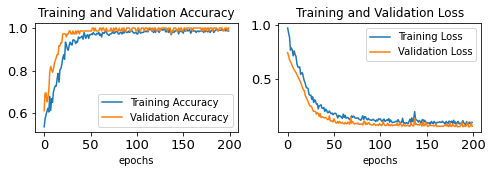

list of classes (n_classes=2)
fast/LR/right
slow/LR/right
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:28:35.244535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:28:35.431555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.3702 - accuracy: 0.8506


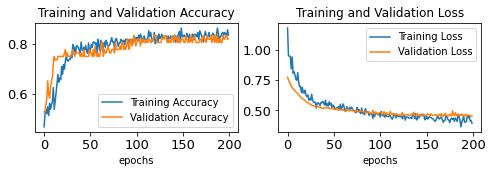

list of classes (n_classes=2)
fast/RL/1m
slow/RL/1m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:28:55.437339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:28:55.625950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.4922 - accuracy: 0.7857


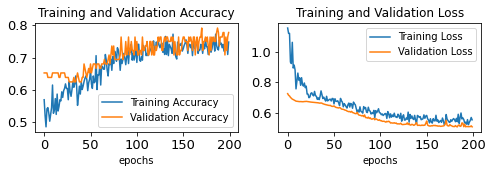

list of classes (n_classes=2)
fast/RL/2m
slow/RL/2m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:29:15.872351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:29:16.063225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.4619 - accuracy: 0.7792


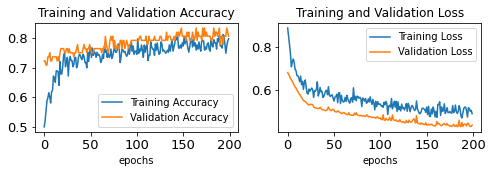

list of classes (n_classes=2)
fast/RL/3m
slow/RL/3m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:29:36.312535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:29:36.500707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.3051 - accuracy: 0.9026


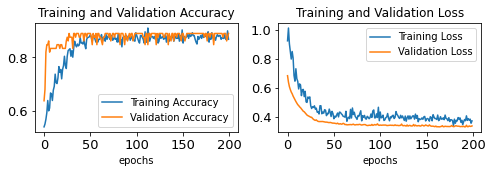

list of classes (n_classes=2)
fast/RL/4m
slow/RL/4m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:29:56.975188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:29:57.166597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 7ms/step - loss: 0.2518 - accuracy: 0.9026


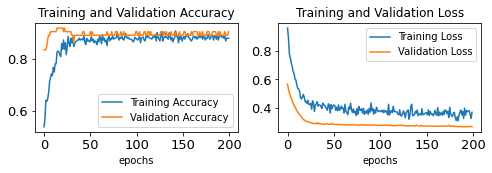

list of classes (n_classes=2)
fast/RL/5m
slow/RL/5m
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:30:17.564340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:30:17.757120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.2675 - accuracy: 0.8896


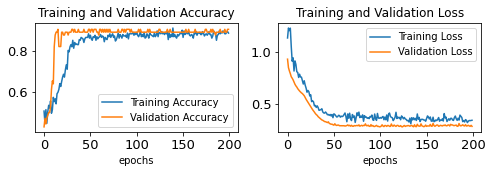

list of classes (n_classes=2)
fast/RL/left
slow/RL/left
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:30:38.954651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:30:39.141279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.3263 - accuracy: 0.8766


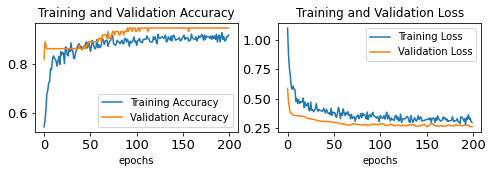

list of classes (n_classes=2)
fast/RL/right
slow/RL/right
---
size of dataset: input (512, 20) and target (512,)


2021-08-18 14:30:59.366304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:30:59.564279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 9ms/step - loss: 0.4178 - accuracy: 0.8831


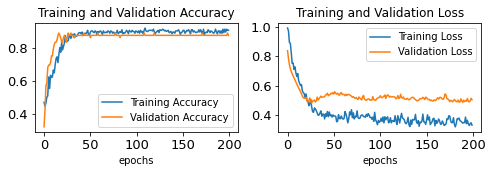

CPU times: user 4min 11s, sys: 2min 31s, total: 6min 43s
Wall time: 4min 50s


In [47]:
%%time 
res_speed_based = {} 
for key, val in speed_based.items():
    res_speed_based[key] = nn_multiClass_Classification(val, batch_size=32)

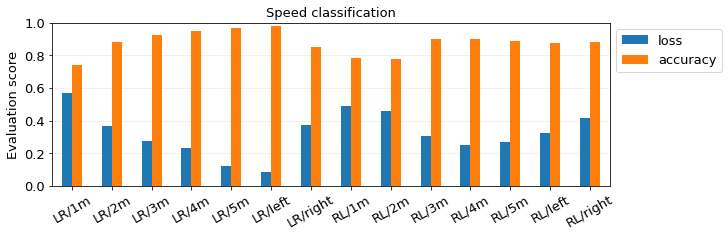

In [95]:
plot_subclass_classification_result(res_speed_based,"Speed classification")

list of classes (n_classes=14)
fast/LR/1m
fast/LR/2m
fast/LR/3m
fast/LR/4m
fast/LR/5m
fast/LR/left
fast/LR/right
fast/RL/1m
fast/RL/2m
fast/RL/3m
fast/RL/4m
fast/RL/5m
fast/RL/left
fast/RL/right
---
size of dataset: input (3584, 20) and target (3584,)


2021-08-18 14:31:20.230466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:31:20.906474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 0s 6ms/step - loss: 1.9024 - accuracy: 0.3197


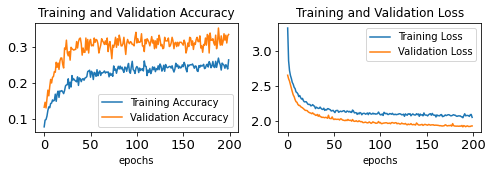

CPU times: user 1min 45s, sys: 1min 7s, total: 2min 52s
Wall time: 2min


(1.902388572692871, 0.3197025954723358)

In [49]:
%%time
nn_multiClass_Classification(motions.classes[:14], batch_size=32)

list of classes (n_classes=14)
slow/LR/1m
slow/LR/2m
slow/LR/3m
slow/LR/4m
slow/LR/5m
slow/LR/left
slow/LR/right
slow/RL/1m
slow/RL/2m
slow/RL/3m
slow/RL/4m
slow/RL/5m
slow/RL/left
slow/RL/right
---
size of dataset: input (3584, 20) and target (3584,)


2021-08-18 14:33:20.355533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-18 14:33:20.991576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 0s 7ms/step - loss: 1.5620 - accuracy: 0.3996


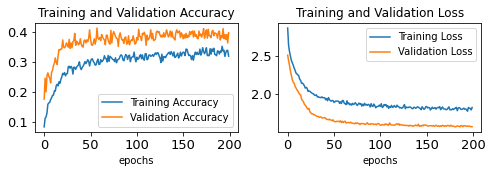

CPU times: user 1min 44s, sys: 1min 6s, total: 2min 51s
Wall time: 1min 59s


(1.5620417594909668, 0.39962825179100037)

In [50]:
%%time
nn_multiClass_Classification(motions.classes[14:], batch_size=32)

#### One vs Rest Classifier

In [51]:
def full_dataset(motion_list):
    y, X_multiClass = [], []
    for m in motion_list:
        print(m)
        X_multiClass.append(X_augmented[y_augmented == m])
        y.append(y_augmented[y_augmented == m])

    X = np.vstack(X_multiClass)
    y = np.hstack(y)
    
    print("size of dataset: input {} and target {}".format(X.shape, y.shape))
    
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    #dummy_y = np_utils.to_categorical(encoded_y)
    
    print("size of dataset: input {} and target {}".format(scaled_X.shape, encoded_y.shape))

    X_train, X_test, y_train, y_test = train_test_split(
                    scaled_X, encoded_y, test_size=0.3, random_state=0)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = full_dataset(motions.classes)

fast/LR/1m
fast/LR/2m
fast/LR/3m
fast/LR/4m
fast/LR/5m
fast/LR/left
fast/LR/right
fast/RL/1m
fast/RL/2m
fast/RL/3m
fast/RL/4m
fast/RL/5m
fast/RL/left
fast/RL/right
slow/LR/1m
slow/LR/2m
slow/LR/3m
slow/LR/4m
slow/LR/5m
slow/LR/left
slow/LR/right
slow/RL/1m
slow/RL/2m
slow/RL/3m
slow/RL/4m
slow/RL/5m
slow/RL/left
slow/RL/right
size of dataset: input (7168, 20) and target (7168,)
size of dataset: input (7168, 20) and target (7168,)


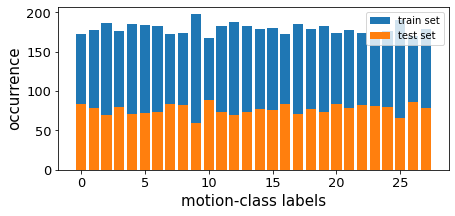

/Users/gimoonnam/miniforge3/envs/tf25/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [89]:
d1 = Counter(y_train)
d2 = Counter(y_test)

plt.figure(figsize=(7,3))
plt.bar(d1.keys(), d1.values(), label="train set") 
plt.bar(d2.keys(), d2.values(), label="test set")
plt.xlabel("motion-class labels", fontsize=15)
plt.ylabel("occurrence",fontsize=15)
plt.legend()
plt.show()

In [91]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

dnns_classifier = OneVsRestClassifier(
                    MLPClassifier(hidden_layer_sizes = [100]*5), n_jobs=-1)
dnns_classifier.fit(X_train, y_train)
dnns_predictions_labels = dnns_classifier.predict(X_test)

print("accuracy: {}".format(np.count_nonzero(y_test == dnns_predictions_labels)/len(y_test)))

accuracy: 0.43375174337517436
CPU times: user 1.14 s, sys: 311 ms, total: 1.46 s
Wall time: 26.4 s


In [90]:
%%time 

svm_classifier = OneVsRestClassifier(SVC(decision_function_shape='ovr'), n_jobs=-1)
svm_classifier.fit(X_train, y_train)
svm_predictions_labels = svm_classifier.predict(X_test)

print("accuracy: {}".format(np.count_nonzero(y_test == svm_predictions_labels)/len(y_test)))

accuracy: 0.35471873547187355
CPU times: user 1.11 s, sys: 95.1 ms, total: 1.21 s
Wall time: 1.91 s
